# Vector store

In [9]:
#!pip uninstall -y -q gensim
!pip install -q gensim

In [10]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import KeyedVectors
import heapq
from collections import defaultdict, namedtuple
import numpy as np
from numpy import float32 as FLOAT_TYPE


In [11]:
# 1. Parameters
VECTOR_SIZE = 100
WINDOW      = 5
MIN_COUNT   = 5
WORKERS     = 4
MAX_WORDS_IN_BATCH = 10000
#MAX_WORDS From https://github.com/piskvorky/gensim/blob/develop/gensim/models/word2vec_inner.pyx#L27

### CustomLineSentence

In [12]:
import itertools
from gensim import utils

class CustomLineSentence:
    def __init__(self, source):
        self.source = source

    def __iter__(self):
        """Iterate through the lines in the source."""
        with utils.open(self.source, 'rb') as fin:
            for line in itertools.islice(fin, None):
                line = utils.to_unicode(line).split()
                i = 0
                while i < len(line):
                    yield line[i: i + MAX_WORDS_IN_BATCH]
                    i += MAX_WORDS_IN_BATCH

class Heapitem(namedtuple('Heapitem', 'count, index, left, right')):
    def __lt__(self, other):
        return self.count < other.count

In [13]:
# 2. Load the text8 corpus as a stream of sentences
sentences = CustomLineSentence('data/text8')

In [14]:
def keep_vocab_item(word, count, min_count):
    default_res = count >= min_count
    return default_res

def _build_heap(wv):
    heap = list(Heapitem(wv.get_vecattr(i, 'count'), i, None, None) for i in range(len(wv.index_to_key)))
    heapq.heapify(heap)
    for i in range(len(wv) - 1):
        min1, min2 = heapq.heappop(heap), heapq.heappop(heap)
        heapq.heappush(
            heap, Heapitem(count=min1.count + min2.count, index=i + len(wv), left=min1, right=min2)
        )
    return heap

def _assign_binary_codes(wv):
    heap = _build_heap(wv)
    
    max_depth = 0
    stack = [(heap[0], [], [])]
    while stack:
        node, codes, points = stack.pop()
        if node[1] < len(wv):  # node[1] = index
            # leaf node => store its path from the root
            k = node[1]
            wv.set_vecattr(k, 'code', codes)
            wv.set_vecattr(k, 'point', points)
            # node.code, node.point = codes, points
            max_depth = max(len(codes), max_depth)
        else:
            # inner node => continue recursion
            points = np.array(list(points) + [node.index - len(wv)], dtype=np.uint32)
            stack.append((node.left, np.array(list(codes) + [0], dtype=np.uint8), points))
            stack.append((node.right, np.array(list(codes) + [1], dtype=np.uint8), points))



In [ ]:
class CustomWord2Vec:
     def __init__(self, sentences=None, vector_size=100, window=5, min_count=5, workers=3):

          corpus_iterable = sentences

          self.sentences = sentences
          self.vector_size = vector_size
          self.window = window
          self.min_count = min_count
          self.workers = workers

          # from Word2Vec parameters
          self.shrink_windows=True
          self.compute_loss=False
          self.sorted_vocab=1
          self.null_word=0
          self.epochs=5
          self.hashfxn=hash
          self.cbow_mean=1
          self.ns_exponent=0.75
          self.negative=5
          self.hs=0
          self.sg=0
          self.min_alpha=0.0001
          self.seed=1
          self.sample=0.001
          self.alpha=0.025
          
          # normal init valuse
          self.train_count = 0
          self.total_train_time = 0
          self.running_training_loss = 0
          self.corpus_count = 0
          self.corpus_total_words = 0


          if not hasattr(self, 'layer1_size'):  # set unless subclass already set (as for Doc2Vec dm_concat mode)
            self.layer1_size = vector_size

          if not hasattr(self, 'wv'):  # set unless subclass already set (eg: FastText)
            self.wv = KeyedVectors(vector_size)
          # EXPERIMENTAL lockf feature; create minimal no-op lockf arrays (1 element of 1.0)
          # advanced users should directly resize/adjust as desired after any vocab growth
          self.wv.vectors_lockf = np.ones(1, dtype=FLOAT_TYPE)  # 0.0 values suppress word-backprop-updates; 1.0 allows

          # Main part build vocab
          self.build_vocab(corpus_iterable=corpus_iterable, corpus_file=None, trim_rule=None)




     def scan_vocab(self, sentences=None, corpus_file=None):
          """Scan the corpus to determine the vocabulary size and word frequencies."""
          if corpus_file:
               sentences = CustomLineSentence(corpus_file) # potentially this could be removed - TODO: test this later

          sentence_no = -1         # start from -1 to count the first sentence as 0 in 
          total_words = 0          # 
          vocab = defaultdict(int)

          for sentence_no, sentence in enumerate(sentences):
            for word in sentence:
                vocab[word] += 1
            total_words += len(sentence)

          corpus_count = sentence_no + 1
          self.raw_vocab = vocab

          return total_words, corpus_count


     def add_null_word(self):
          word = '\0'
          self.wv.key_to_index[word] = len(self.wv)
          self.wv.index_to_key.append(word)
          self.wv.set_vecattr(word, 'count', 1)

     def create_binary_tree(self):
          _assign_binary_codes(self.wv)

     def make_cum_table(self, domain=2**31 - 1): # TODO: I want to reamke this cum table
        """Create a cumulative-distribution table using stored vocabulary word counts for
        drawing random words in the negative-sampling training routines.

        To draw a word index, choose a random integer up to the maximum value in the table (cum_table[-1]),
        then finding that integer's sorted insertion point (as if by `bisect_left` or `ndarray.searchsorted()`).
        That insertion point is the drawn index, coming up in proportion equal to the increment at that slot.

        """
        vocab_size = len(self.wv.index_to_key)
        self.cum_table = np.zeros(vocab_size, dtype=np.uint32)
        # compute sum of all power (Z in paper)
        train_words_pow = 0.0
        for word_index in range(vocab_size):
            count = self.wv.get_vecattr(word_index, 'count')
            train_words_pow += count**float(self.ns_exponent)
        cumulative = 0.0
        for word_index in range(vocab_size):
            count = self.wv.get_vecattr(word_index, 'count')
            cumulative += count**float(self.ns_exponent)
            self.cum_table[word_index] = round(cumulative / train_words_pow * domain)
        if len(self.cum_table) > 0:
            assert self.cum_table[-1] == domain

     def estimate_memory(self, vocab_size=None, report=None):
          """Estimate required memory for a model using current settings and provided vocabulary size.

          Parameters
          ----------
          vocab_size : int, optional
               Number of unique tokens in the vocabulary
          report : dict of (str, int), optional
               A dictionary from string representations of the model's memory consuming members to their size in bytes.

          Returns
          -------
          dict of (str, int)
               A dictionary from string representations of the model's memory consuming members to their size in bytes.

          """
          vocab_size = vocab_size or len(self.wv)
          report = report or {}
          report['vocab'] = vocab_size * (700 if self.hs else 500)
          report['vectors'] = vocab_size * self.vector_size * np.dtype(FLOAT_TYPE).itemsize
          if self.hs:
               report['syn1'] = vocab_size * self.layer1_size * np.dtype(FLOAT_TYPE).itemsize
          if self.negative:
               report['syn1neg'] = vocab_size * self.layer1_size * np.dtype(FLOAT_TYPE).itemsize
          report['total'] = sum(report.values())

          return report

     def prepare_vocab(
               self, update=False, keep_raw_vocab=False, trim_rule=None
          ):
          print("Preparing vocab...")
          min_count = self.min_count
          sample = self.sample
          drop_total = drop_unique = 0
          
          self.effective_min_count = min_count # set effective_min_count to min_count in case max_final_vocab isn't set

          new_total = pre_exist_total = 0
          new_words = []
          pre_exist_words = []



          for word, v in self.raw_vocab.items():

               effective_min_count = self.effective_min_count
               if keep_vocab_item(word, v, effective_min_count):
                    if self.wv.has_index_for(word):
                         pre_exist_words.append(word)
                         pre_exist_total += v

                    else:
                         new_words.append(word)
                         new_total += v
                         self.wv.key_to_index[word] = len(self.wv.index_to_key)
                         self.wv.index_to_key.append(word)
               else:
                    drop_unique += 1
                    drop_total += v

          self.wv.allocate_vecattrs(attrs=['count'], types=[type(0)])
          for word in self.wv.index_to_key:
               self.wv.set_vecattr(word, 'count', self.wv.get_vecattr(word, 'count') + self.raw_vocab.get(word, 0))
     

          original_unique_total = len(pre_exist_words) + len(new_words) + drop_unique
          pre_exist_unique_pct = len(pre_exist_words) * 100 / max(original_unique_total, 1)
          new_unique_pct = len(new_words) * 100 / max(original_unique_total, 1)


          retain_words = new_words + pre_exist_words
          retain_total = new_total + pre_exist_total



          # Precalculate each vocabulary item's threshold for sampling
          if not sample:
               # no words downsampled
               threshold_count = retain_total
          elif sample < 1.0:
               # traditional meaning: set parameter as proportion of total
               threshold_count = sample * retain_total
          else:
               # new shorthand: sample >= 1 means downsample all words with higher count than sample
               threshold_count = int(sample * (3 + np.sqrt(5)) / 2)

          downsample_total, downsample_unique = 0, 0
          for w in retain_words:
               v = self.raw_vocab[w]
               word_probability = (np.sqrt(v / threshold_count) + 1) * (threshold_count / v)
               if word_probability < 1.0:
                    downsample_unique += 1
                    downsample_total += word_probability * v
               else:
                    word_probability = 1.0
                    downsample_total += v
               
               self.wv.set_vecattr(w, 'sample_int', np.uint32(word_probability * (2**32 - 1)))

    
          self.raw_vocab = defaultdict(int)


          # return from each step: words-affected, resulting-corpus-size, extra memory estimates
          report_values = {
               'drop_unique': drop_unique, 'retain_total': retain_total, 'downsample_unique': downsample_unique,
               'downsample_total': int(downsample_total), 'num_retained_words': len(retain_words)
          }
          print(f"Report values: {report_values}")

          if self.null_word:
            # create null pseudo-word for padding when using concatenative L1 (run-of-words)
            # this word is only ever input – never predicted – so count, huffman-point, etc doesn't matter
            self.add_null_word()

          if self.sorted_vocab and not update:
               self.wv.sort_by_descending_frequency()

          if self.hs:
               # add info about each word's Huffman encoding
               self.create_binary_tree()

          print("negative: ", self.negative)
          if self.negative:
               # build the table for drawing random words (for negative sampling)
               self.make_cum_table() # TODO: I want to remake this, 

          return report_values




     def build_vocab(self, corpus_iterable, corpus_file=None, trim_rule=None, progress_per=10000):
          # part 1
          
          total_words, corpus_count = self.scan_vocab(sentences=corpus_iterable, corpus_file=corpus_file)
          print(f"Total words: {total_words}, Corpus count: {corpus_count}")
          self.corpus_count = corpus_count
          self.corpus_total_words = total_words
          
          # part 2 

          report_values = self.prepare_vocab()
     



     def train():
          pass
          


In [16]:
sentences = CustomLineSentence('data/text8')
model = CustomWord2Vec(
    sentences,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=WORKERS
)

Total words: 17005207, Corpus count: 1701
Preparing vocab...
Report values: {'drop_unique': 182564, 'retain_total': 16718844, 'downsample_unique': 38, 'downsample_total': 12506280, 'num_retained_words': 71290}
negative:  5


In [17]:

# 3. Train Word2Vec
model = Word2Vec(
    sentences,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=WORKERS
)

# 4. Save the trained model
model.save('models/text8_w2v_100d.model')

# 5. Quick sanity check
print(model.wv.most_similar('king', topn=10))

[('prince', 0.7428317666053772), ('queen', 0.7263941764831543), ('emperor', 0.7050734758377075), ('throne', 0.6763173937797546), ('kings', 0.6761729717254639), ('constantine', 0.6701391339302063), ('regent', 0.6658718585968018), ('vii', 0.6653949022293091), ('sultan', 0.6621578335762024), ('antiochus', 0.6612289547920227)]


# We want to use PCA, WHY.

PCA (Principal Component Analysis) is used to reduce the dimensionality of high-dimensional data, such as embeddings, while preserving as much of the original information (variance) as possible.

We are going to give it `n_components=3` to reduce the embeddings to 3 dimensions.

In my test case, we just test the first 100 words.

Also, what I can see when I look at the data is that we have a lot of words that are stopwords. We are going to want to remove them.

(71290, 100)


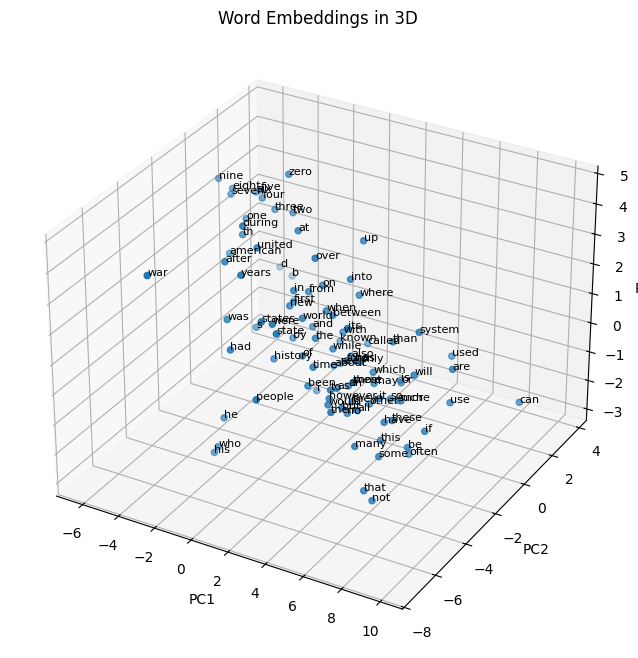

In [18]:
from sklearn.decomposition import PCA

weights = model.wv.vectors

print(weights.shape)  # (number of words, vector size)
import matplotlib.pyplot as plt

# Reduce vectors to 3D
pca = PCA(n_components=3)
weights_3d = pca.fit_transform(weights)

# Plot the first 100 words in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weights_3d[:100, 0], weights_3d[:100, 1], weights_3d[:100, 2])

# Annotate points with words
words = list(model.wv.index_to_key)
for i in range(100):
    ax.text(weights_3d[i, 0], weights_3d[i, 1], weights_3d[i, 2], words[i], size=8)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Word Embeddings in 3D')
plt.show()
